In [ ]:
!pip install ultralytics

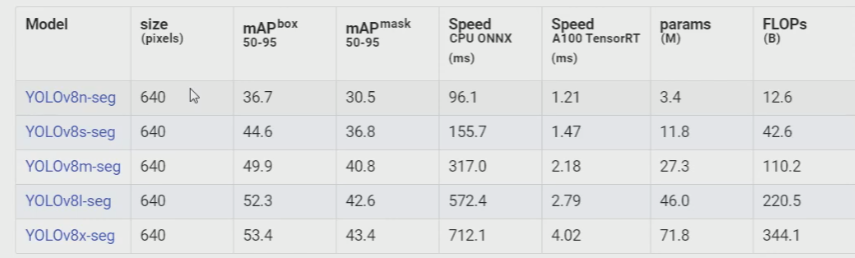

In [ ]:
from ultralytics import YOLO
path = 'gaga.jpg'
model = YOLO('yolov8l-seg.pt')
results = model.predict(
    source=path,  # или "video.mp4", 0 (веб-камера)
    conf=0.3,  # <- Устанавливаем порог уверенности (от 0.0 до 1.0)
    save=True  # сохранить результат
)

results[0].show()  # отображение результата с масками
print(results[0].boxes.cls.cpu().numpy(), 'Полученные классы')



image 1/1 /content/gaga.jpg: 576x640 3 persons, 1 bottle, 1 cup, 2 pizzas, 2 chairs, 2 dining tables, 10498.4ms
Speed: 6.1ms preprocess, 10498.4ms inference, 166.7ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs/segment/predict7


## Словарь с классами, чтобы вырезать объекты в классе по местоположению


In [ ]:
# Создание словаря для хранения классов и их масок
mask_dict = {}

# Получение результатов
boxes = results[0].boxes  # Для получения классов и координат
classes = boxes.cls.cpu().numpy()  # Классы
masks = results[0].masks  # Маски сегментации
xyxy = boxes.xyxy.cpu().numpy()  # Координаты bbox для сортировки по x

# Проверка наличия масок
if masks is not None:
    mask_data = masks.data.cpu().numpy()  # Маски в формате numpy (H, W, num_instances)

    # Заполнение словаря
    for i, (cls, bbox) in enumerate(zip(classes, xyxy)):
        cls = int(cls)  # Преобразуем класс в int
        if cls not in mask_dict:
            mask_dict[cls] = []
        # Добавляем маску и координаты центра для сортировки
        mask_dict[cls].append({
            'mask': mask_data[i],  # Маска как numpy массив
            'center_x': (bbox[0] + bbox[2]) / 2  # Центр по x для сортировки
        })

    # Сортировка масок по center_x для каждого класса
    for cls in mask_dict:
        mask_dict[cls].sort(key=lambda x: x['center_x'])  # Сортируем по x-центру

    # Удаляем center_x из словаря, оставляем только маски
    for cls in mask_dict:
        mask_dict[cls] = [item['mask'] for item in mask_dict[cls]]

    # Вывод словаря
    print("Словарь классов и их масок:", {cls: len(masks) for cls, masks in mask_dict.items()})

Словарь классов и их масок: {0: 3, 53: 2, 56: 2, 41: 1, 60: 2, 39: 1}


In [ ]:
import cv2
import numpy as np
image = cv2.imread(path)

masks = results[0].masks # маски классов
class_idx = results[0].boxes.cls.cpu().numpy() # получаем индексы классов и переводим в np на cpu
orig_image = results[0].orig_img

print(class_idx)
results[0].names

[          0           0          56           0           0           0           0           0          27           0           0          27          27          27          27           0           0           0           0           0           0          26          74          27           0           0
           0]


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

# Первоначальный вариант вырезки

In [119]:
masks_np = masks.data.cpu().numpy()
H_orig, W_orig = orig_image.shape[:2] # [H, W, C] -> [H, W]
correct_class = np.arange(79)
classes_mask = []
for mask, cls in zip(masks_np, class_idx): # добавляем маску класса, который нам нужен
    if cls in correct_class:
          mask_resized = cv2.resize(mask, (W_orig, H_orig))
          classes_mask.append(mask_resized)

comb_mask = np.zeros((H_orig, W_orig), dtype=np.uint8)
for mask in classes_mask:
    comb_mask = np.logical_or(comb_mask, mask) # логическое или, дает 1, если одно из слагаемых = 1
comb_mask_3d = np.stack([comb_mask] * 3, axis=-1)

blurred_mask = cv2.GaussianBlur(comb_mask.astype(np.float32), (5, 5), 0)
# Прозрачный фон
b, g, r = cv2.split(orig_image)
alpha = blurred_mask.astype(np.uint8) * 255  # Альфа-канал (0 = прозрачный, 255 = непрозрачный)

print(r.shape, alpha.shape)
image_rgba = cv2.merge([b, g, r, alpha])

cv2.imwrite("output.png", image_rgba)


(833, 960) (833, 960)


True

# Новый вариант

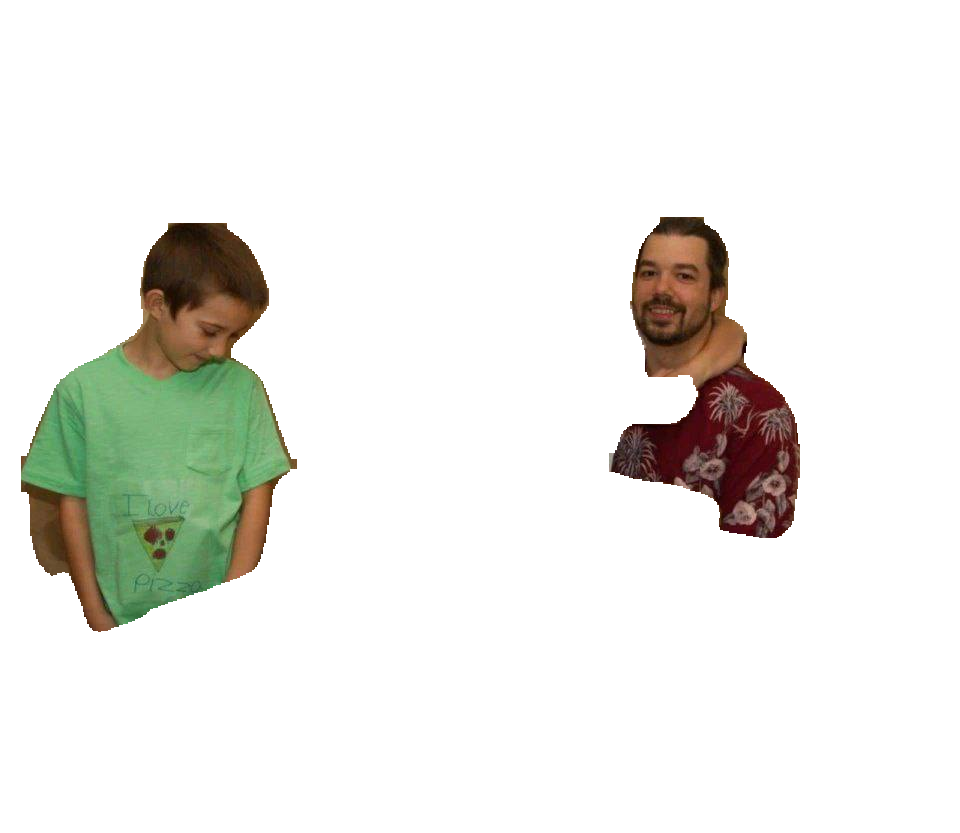

In [128]:
from google.colab.patches import cv2_imshow

def get_cutted_class (correct_class:int, position:list, input_path:str):
    correct_class = correct_class  # Класс, который нужен (например, 0 для людей)
    position = position # Позиция маски (например, 2 для второго слева)
    orig_image = cv2.imread(input_path)  # Исходное изображение


    H_orig, W_orig = orig_image.shape[:2]  # [H, W, C] -> [H, W]
    selected_masks = []
    for i in range(len(position)):
        selected_mask = cv2.resize(mask_dict[correct_class][position[i]].astype(np.uint8), (W_orig, H_orig), interpolation=cv2.INTER_NEAREST)
        # Выбор маски для указанного человека
        selected_masks.append(selected_mask)  # Маска, например, формы (576, 640)

    comb_mask = np.zeros((H_orig, W_orig), dtype=np.uint8)
    for mask in selected_masks:
        comb_mask = np.logical_or(comb_mask, mask)

    # Прозрачный фон
    b, g, r = cv2.split(orig_image)
    alpha = comb_mask.astype(np.uint8) * 255  # Альфа-канал (0 = прозрачный, 255 = непрозрачный)

    # Создание RGBA изображения
    image_rgba = cv2.merge([b, g, r, alpha])

    return image_rgba

cv2_imshow(get_cutted_class(0, [0,2], input_path="gaga.jpg"))

# Сохранение результата
#cv2.imwrite(output_path, get_cutted_class(0, 1, input_path="gaga.jpg"))
#print(f"Изображение с маской {position}-го объекта класса {correct_class} сохранено как {output_path}")